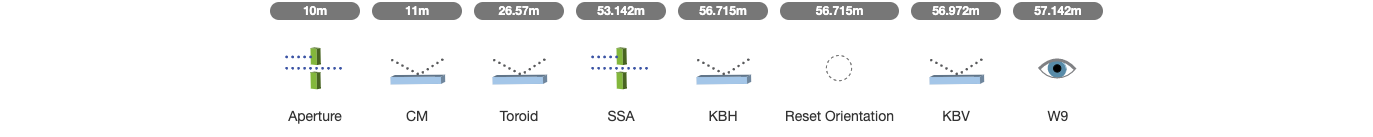

In [1]:
from IPython.display import Image
# original shadow simulation: https://www.sirepo.com/shadow#/beamline/x0UKaW70
display(Image('Beamline-with-mirrors.png'))

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from Shadow.ShadowPreprocessorsXraylib import prerefl, pre_mlayer, bragg
from pykern import pkjson
from pykern.pkcollections import PKDict
from pykern.pkdebug import pkdc, pkdp
from sirepo.template import transfer_mat_bl
from srxraylib.sources import srfunc
import Shadow
import math
import numpy
import re
import scipy.linalg as sla

import subprocess

In [3]:
alpha = 0
# epsilon = 1e-06
epsilon = 1e-6
energy = 1000.0

In [4]:
# from https://github.com/radiasoft/rslight/blob/main/Gaussian/gauss_apert-01.py

#  Propagate a 4x4 covariance matrix Sigma through a Gaussian aperture of (Gaussian, not not hard-edge)
#  size parameters a_gx, a_gy
#  NB:  assumed ordering of the variables is x, y, theta_x, theta_y
def gauss_apert_4x4(Sigma, lambda_rad, a_gx, a_gy):
    Sigma_inv = sla.inv(Sigma)
    A = 1.0 *Sigma_inv[0:2,0:2]
    B = 1.0 *Sigma_inv[0:2,2:4]
    C = numpy.transpose(B)
    D = 1.0 *Sigma_inv[2:4,2:4]

    A_A = numpy.zeros([2,2], dtype=numpy.float32)
    A_A[0,0] = 2. /a_gx**2
    A_A[1,1] = 2. /a_gy**2

    D_inv = sla.inv(D)
    D_A_inv = numpy.zeros([2,2], dtype=numpy.float32)
    D_A_inv[0,0] = 1. /a_gx**2
    D_A_inv[1,1] = 1. /a_gy**2
    D_A_inv *= lambda_rad**2 /(8. *numpy.pi *numpy.pi)

    D_f = sla.inv(D_inv +D_A_inv)
    BDi = numpy.matmul(B, D_inv)
    DiC = numpy.matmul(D_inv, C)  #  == numpy.transpose(BDi)
    C_f = numpy.matmul(D_f, DiC)
    B_f = numpy.transpose(C_f)    #  ==  numpy.matmul(BDi, D_f)
    A_f = A +A_A -numpy.matmul(BDi, C) +numpy.matmul(BDi, numpy.matmul(D_f, DiC))

    Sigma_inv[0:2,0:2] = 1.0 *A_f
    Sigma_inv[0:2,2:4] = 1.0 *B_f
    Sigma_inv[2:4,0:2] = 1.0 *C_f
    Sigma_inv[2:4,2:4] = 1.0 *D_f

    return sla.inv(Sigma_inv)

$f(x, \theta) = \frac{1}{2 \pi \epsilon} e^{-\frac{1}{\epsilon} (\gamma x^2 + 2 \alpha x \theta + \beta \theta^2)}$

In [5]:
def rays_sigma(rays, idx):
    return numpy.sqrt(numpy.mean(rays[:, idx] ** 2))

def create_sigma_matrix():
    source = Shadow.Source()
    beam = Shadow.Beam()
    
    source.NPOINT = 100000
    source.ISTAR1 = 567656

    source.FSOUR = 3
    source.WXSOU = 0.100000001
    source.WZSOU = 0.20000000299999998
    source.SIGMAX = 0.00442
    source.SIGMAZ = 0.002385
    source.FDISTR = 3
    source.SIGDIX = 2.232206e-06
    source.SIGDIZ = 4.1368340000000004e-06
    source.CONE_MAX = 0.0
    source.CONE_MIN = 0.0
    source.FSOURCE_DEPTH = 3
    source.WYSOU = 0.2
    source.SIGMAY = 0.001
    source.F_COLOR = 1
    source.F_POLAR = 1
    source.F_COHER = 0
    source.POL_ANGLE = 0.0
    source.POL_DEG = 0.0
    source.HDIV1 = 0.0
    source.HDIV2 = 0.0
    source.VDIV1 = 0.0
    source.VDIV2 = 0.0
    source.F_PHOT = 0
    source.PH1 = energy
    source.F_BOUND_SOUR = 0
    beam.genSource(source)
    
    rays = beam.rays
    sigmax = rays_sigma(rays, 0)
    sigdix = rays_sigma(rays, 3)
    sigmaz = rays_sigma(rays, 2)
    sigdiz = rays_sigma(rays, 5)
    res = numpy.matrix([
        [sigmax ** 2, 0, 0, 0],
        [0, sigdix ** 2, 0, 0],
        [0, 0, sigmaz ** 2, 0],
        [0, 0, 0, sigdiz ** 2],
    ])
    pkdp('sigma_mat:\n{}', res)
    return res

def apply_aperture(oe, mat):
    pkdp('aperture size [m]: {} x {}',
         oe.RX_SLIT[0] * 1e-2,
         oe.RZ_SLIT[0] * 1e-2)
    Pmat = numpy.array([
        [1.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]])
    res = gauss_apert_4x4(
        # Convert Sigma to x, y, xp, yp, via Pmat Sigma Pmat (since Pmat is symmetric)
        numpy.matmul(numpy.matmul(Pmat, mat), Pmat),
        # wavelength [cm]
        1.2398419843320026 / energy * 1e-6 * 1e2,
        # aperture x, y [cm]
        oe.RX_SLIT[0],
        oe.RZ_SLIT[0],
    )
    return numpy.matmul(numpy.matmul(Pmat, res), Pmat)

def assert_no_lost_rays(beam):
    lost = []
    LOST_RAY_FLAG = 9
    for i in range(len(beam.rays)):
        if beam.rays[i][LOST_RAY_FLAG] != 1:
            lost.append(i)
    if len(lost):
        raise AssertionError(
            'Lost tracking particle(s) # {}'.format(
                ', '.join(str(v) for v in lost)),
        )
     

emit_x_vals = []
emit_z_vals = []

def calculate_stats(pos, oe, beam):
    """
    pos: position of element along optical axis [cm]
    oe: Shadow optical element object
    beam: Shadow beam object with propagated rays
    sigma_mat: sigma matrix
    """
    
    global alpha
    global sigma_mat
    
    #TODO(pjm): this calculates the Tmat for the constant sigma_mat
    # need to compute the Tmat element by element instead
    if oe and oe.I_STOP[0] == 0 and oe.RX_SLIT[0] != 0 and oe.RZ_SLIT[0] != 0:
        pkdp('calculate stats should be processing aperture')
        #TODO(pjm): the element is an aperture
        # res2 = apply_aperture(oe, beam, res)
        res = sigma_mat
        res2 = apply_aperture(oe, res)
        sigma_mat = res2
        # pkdp('sigma matrix (aperture): \n{}', sigma_mat)
        #TODO(pjm): need to compute and save the new matrix with the aperture changes
        # pkdp('matrix before aperture:\n{}', res)
        # pkdp('matrix after aperture:\n{}', res2)
    else:
        pkdp('calculate stats should be processing oe not an aperture')
        Tmat, x_prop_cen, xp_prop_cen, z_prop_cen, zp_prop_cen = transfer_mat_bl.tmat_calc(beam.duplicate(), epsilon)
        res = Tmat * sigma_mat * numpy.transpose(Tmat)
        sigma_mat = res  # update sigma_mat
        
        # calculate horizontal and vertical emittance
        sigxdix=res[0,1] * 1e-2
        sigzdiz=res[2,3] * 1e-2
        emit_x = numpy.sqrt(res[0,0] * res[1,1] - res[0,1] * res[0,1])
        emit_z = numpy.sqrt(res[2,2] * res[3,3] - res[2,3] * res[2,3])
        emit_x_vals.append(emit_x)
        emit_z_vals.append(emit_z)
        
        # sigx_sq_vals.append(sigma_mat[0,0])
        # sigpx_sq_vals.append(sigma_mat[1,1])
        pkdp('sigma matrix (regular element): \n{}', sigma_mat)
        pos += (oe.T_SOURCE if oe else 0)
        # if oe:
            # oe.ALPHA is in radians after traceOE()
        alpha = int(alpha + 180 / math.pi * oe.ALPHA) % 360
        beam_stats.append(PKDict(
            isRotated=True if alpha == 90 or alpha == 270 else False,
            s=pos * 1e-2,
            x=x_prop_cen,
            xp=xp_prop_cen,
            z=z_prop_cen,
            zp=zp_prop_cen,
            matrix=Tmat.tolist(),
            sigma_mx=res.tolist(),
            sigmax=math.sqrt(res[0, 0]) * 1e-2,
            sigdix=math.sqrt(res[1, 1]),
            sigmaz=math.sqrt(res[2, 2]) * 1e-2,
            sigdiz=math.sqrt(res[3, 3]),
            # sigxdix=res[0,1] * 1e-2,
            # sigzdiz=res[2,3] * 1e-2,
            # emit_x = numpy.sqrt(res[0,0] * res[1,1] - res[0,1] * res[0,1]),
            # emit_z = numpy.sqrt(res[2,2] * res[3,3] - res[2,3] * res[2,3]),
        ))
    
    return pos

def divide_drift(pos, beam, count, distance, divisions=100):
    
    if distance < 1e-3:
        return
    for i in range(divisions):
        beam0 = beam.duplicate()      # check Python variable assignment (deepcopy?)
        oe = Shadow.OE()
        oe.DUMMY = 1.0
        oe.set_empty(ALPHA=0)
        oe.FWRITE = 3
        oe.T_IMAGE = 0.0
        oe.T_SOURCE = distance / divisions
        beam0.traceOE(oe, count)
        count += 1
        pos = calculate_stats(pos, oe, beam0)
    return pos

def process_stats():
    def compute_angx(x, z, xz, scale=1):
        x = numpy.array(x)
        z = numpy.array(z)
        xz = numpy.array(xz)
        return ((1/2) * numpy.arctan(2 * scale * xz / (x ** 2 - z ** 2))).tolist()

    def rotated_values(stats, field):
        if field == 'sigmaxz':
            return [-v.sigma_mx[0][2] if v.isRotated else v.sigma_mx[0][2] for v in stats]
        if field == 'sigmaxpzp':
            return [-v.sigma_mx[1][3] if v.isRotated else v.sigma_mx[1][3] for v in stats]
        if re.search('z', field):
            f = re.sub('z', 'x', field)
        else:
            f = re.sub('x', 'z', field)
        return [v[f] if v.isRotated else v[field] for v in stats]

    res = PKDict(
        s=[v.s for v in beam_stats],
    )
    for f in ('sigmax', 'sigdix', 'sigmaz', 'sigdiz', 'sigmaxz', 'sigmaxpzp', 'x', 'xp', 'z', 'zp'):
        res[f] = rotated_values(beam_stats, f)
    res.angxz = compute_angx(res.sigmax, res.sigmaz, res.sigmaxz, scale=1e-4)
    res.angxpzp = compute_angx(res.sigdix, res.sigdiz, res.sigmaxpzp)
    return res

def run_shadow_simulation():
    
    global sigxx_init
    global sigxtheta_init
    global sigthetatheta_init
    
    global sigxx_fin
    global sigxtheta_fin
    global sigthetatheta_fin
    
    global sigzz_init
    global sigztheta_init
    global sigthetathetaz_init
    
    global sigzz_fin
    global sigztheta_fin
    global sigthetathetaz_fin
    
    global ps_X
    global ps_thetaX
    global ps_Z
    global ps_thetaZ
    
    global ps_dens_x_init
    global ps_dens_z_init
    
    global ps_dens_x_fin
    global ps_dens_z_fin
    
    pkdp('starting shadow simulation')
    beam0 = transfer_mat_bl.create_mat_rays(epsilon, energy)
    # pkdp('initial beam: {}', beam)
    # pos = calculate_stats(0, None, beam)
    
    
    pos = divide_drift(0.0, beam0.duplicate(), 1, 1400.0)
    
    
    # create x [cm] and theta [rad] arrays for calculating phase space function
    ps_nx = 150
    ps_nz = 150
    ps_nthetax = 150
    ps_nthetaz = 150
    ps_x_vals = numpy.linspace(-1.5e-2, 1.5e-2, ps_nx)
    ps_z_vals = numpy.linspace(-1.5e-2, 1.5e-2, ps_nz)
    ps_thetax_vals = numpy.linspace(-30e-6, 30e-6, ps_nthetax)
    ps_thetaz_vals = numpy.linspace(-30e-6, 30e-6, ps_nthetaz)
    
    ps_X, ps_thetaX = numpy.meshgrid(ps_x_vals, ps_thetax_vals)
    ps_Z, ps_thetaZ = numpy.meshgrid(ps_z_vals, ps_thetaz_vals)
    
    #****before aperture****
    
    # pull out sigma matrix components before aperture for analysis
    sigxx_init = sigma_mat[0,0]
    sigxtheta_init = sigma_mat[0,1]
    sigthetatheta_init = sigma_mat[1,1]
    
    sigzz_init = sigma_mat[2,2]
    sigztheta_init = sigma_mat[2,3]
    sigthetathetaz_init = sigma_mat[3,3]
    
    emit_x_init = numpy.sqrt(sigma_mat[0,0] * sigma_mat[1,1] - sigma_mat[0,1] * sigma_mat[0,1])
    emit_z_init = numpy.sqrt(sigma_mat[2,2] * sigma_mat[3,3] - sigma_mat[2,3] * sigma_mat[2,3])
    
    beta_x_init = sigxx_init / emit_x_init
    beta_z_init = sigzz_init / emit_z_init
    
    gamma_x_init = sigthetatheta_init / emit_x_init
    gamma_z_init = sigthetathetaz_init / emit_z_init
    
    alpha_x_init = -sigxtheta_init / emit_x_init
    alpha_z_init = -sigztheta_init / emit_z_init
    
    ps_dens_x_init = 1 / (2 * numpy.pi * emit_x_init) * numpy.exp( (-1 / emit_x_init) * \
                    (gamma_x_init * ps_X**2 + 2 * alpha_x_init * ps_X * ps_thetaX + beta_x_init * ps_thetaX**2))
    
    ps_dens_z_init = 1 / (2 * numpy.pi * emit_z_init) * numpy.exp( (-1 / emit_z_init) * \
                    (gamma_z_init * ps_Z**2 + 2 * alpha_z_init * ps_Z * ps_thetaZ + beta_z_init * ps_thetaZ**2))
    
#     Nx = 75
#     Npx = 75
#     sigma_px = 0.005
#     sigma_x = 0.001
#     x_max = 3 * sigma_x
#     px_max = 3 * sigma_px

#     x = np.linspace(-x_max, x_max, Nx)
#     px = np.linspace(-px_max, px_max, Npx)

#     X,Px = np.meshgrid(x, px)


#     wigner = np.exp(-X**2 / (sigma_x **2 ))*np.exp(-Px**2 / (sigma_px**2))

#     plt.figure()
#     plt.contourf(X, Px, wigner, 100)
#     plt.show()
    
    
    
    
    # ps_vals_x_init = (1 / (2 * numpy.pi * emit_x_init)) numpy.exp(-(1/emit_x_init) * (numpy.multiply(gamma_x_init, numpy.square(ps_x_vals)) \
                     # + (numpy.multiply(2, numpy.multiply( alpha_x_init, numpy.multiply(ps_x_vals, ps_theta_vals)))) + (numpy.multiply(beta_x_init, numpy.square(ps_theta_vals)))       )     )
    
    oe = Shadow.OE()
    oe.DUMMY = 1.0
    oe.set_empty().set_screens()
    oe.I_SLIT[0] = 1
    oe.K_SLIT[0] = 0
    oe.I_STOP[0] = 0
    oe.RX_SLIT[0] = 0.005
    oe.RZ_SLIT[0] = 0.0045
    oe.CX_SLIT[0] = 0.0
    oe.CZ_SLIT[0] = 0.0
    oe.FWRITE = 3
    oe.T_IMAGE = 0.0
    oe.T_SOURCE = 0.0
    beam01 = beam0.duplicate()
    beam01.traceOE(oe, 2)
    pos = calculate_stats(pos, oe, beam01)
    
    #****after aperture****
    
    # pull out sigma matrix components after aperture for analysis
    sigxx_fin = sigma_mat[0,0]
    sigxtheta_fin = sigma_mat[0,1]
    sigthetatheta_fin = sigma_mat[1,1]
    
    sigzz_fin = sigma_mat[2,2]
    sigztheta_fin = sigma_mat[2,3]
    sigthetathetaz_fin = sigma_mat[3,3]
    
    emit_x_fin = numpy.sqrt(sigma_mat[0,0] * sigma_mat[1,1] - sigma_mat[0,1] * sigma_mat[0,1])
    emit_z_fin = numpy.sqrt(sigma_mat[2,2] * sigma_mat[3,3] - sigma_mat[2,3] * sigma_mat[2,3])
    
    beta_x_fin = sigxx_fin / emit_x_fin
    beta_z_fin = sigzz_fin / emit_z_fin
    
    gamma_x_fin = sigthetatheta_fin / emit_x_fin
    gamma_z_fin = sigthetathetaz_fin / emit_z_fin
    
    alpha_x_fin = -sigxtheta_fin / emit_x_fin
    alpha_z_fin = -sigztheta_fin / emit_z_fin
    
    ps_dens_x_fin = 1 / (2 * numpy.pi * emit_x_fin) * numpy.exp( (-1 / emit_x_fin) * \
                    (gamma_x_fin * ps_X**2 + 2 * alpha_x_fin * ps_X * ps_thetaX + beta_x_fin * ps_thetaX**2))
    
    ps_dens_z_fin = 1 / (2 * numpy.pi * emit_z_fin) * numpy.exp( (-1 / emit_z_fin) * \
                    (gamma_z_fin * ps_Z**2 + 2 * alpha_z_fin * ps_Z * ps_thetaZ + beta_z_fin * ps_thetaZ**2))
    
    pos = divide_drift(pos, beam0.duplicate(), 3, 1450.0)
    
    # kb mirror 1
    oe = Shadow.OE()
    oe.DUMMY = 1.0
    oe.FMIRR = 2
    oe.ALPHA = 90
    oe.FHIT_C = 1
    oe.F_EXT = 0
    oe.F_DEFAULT = 0
    oe.SSOUR = 2850.0
    oe.SIMAG = 900.0
    oe.THETA = 87.99802816803339
    oe.F_CONVEX = 0
    oe.FCYL = 1
    oe.CIL_ANG = 0.0
    oe.FSHAPE = 1
    oe.RWIDX1 = 25.0
    oe.RWIDX2 = 25.0
    oe.RLEN1 = 25.0
    oe.RLEN2 = 25.0
    oe.T_INCIDENCE = 87.99802816803339
    oe.T_REFLECTION = 87.99802816803339
    oe.FWRITE = 3
    oe.T_IMAGE = 0.0
    oe.T_SOURCE = 0.0
    beam01 = beam0.duplicate()
    beam01.traceOE(oe, 4)
    pos = calculate_stats(pos, oe, beam01)

    # reset orientation
    oe = Shadow.OE()
    oe.DUMMY = 1.0
    oe.set_empty(ALPHA=270)
    oe.FWRITE = 3
    oe.T_IMAGE = 0.0
    oe.T_SOURCE = 0.0
    beam01 = beam0.duplicate()
    beam01.traceOE(oe, 5)
    pos = calculate_stats(pos, oe, beam01)

    pos = divide_drift(pos, beam0.duplicate(), 6, 100.0)
    
    # kb mirror 2
    oe = Shadow.OE()
    oe.DUMMY = 1.0
    oe.FMIRR = 2
    oe.ALPHA = 0
    oe.FHIT_C = 1
    oe.F_EXT = 0
    oe.F_DEFAULT = 0
    oe.SSOUR = 2950.0
    oe.SIMAG = 800.0
    oe.THETA = 87.99802816803339
    oe.F_CONVEX = 0
    oe.FCYL = 1
    oe.CIL_ANG = 0.0
    oe.FSHAPE = 1
    oe.RWIDX1 = 25.0
    oe.RWIDX2 = 25.0
    oe.RLEN1 = 25.0
    oe.RLEN2 = 25.0
    oe.T_INCIDENCE = 87.99802816803339
    oe.T_REFLECTION = 87.99802816803339
    oe.FWRITE = 3
    oe.T_IMAGE = 0.0
    oe.T_SOURCE = 0.0
    beam01 = beam0.duplicate()
    beam01.traceOE(oe, 7)
    pos = calculate_stats(pos, oe, beam01)
 
    # pos = divide_drift(pos, beam0.duplicate(), 8, 800.0)
    
    # propagate it a bit further past the focus
    pos = divide_drift(pos, beam0.duplicate(), 8, 800.0 * 2.0)
    
    oe = Shadow.OE()
    oe.DUMMY = 1.0
    oe.set_empty()
    oe.FWRITE = 3
    oe.T_IMAGE = 0.0
    oe.T_SOURCE = 0.0
    beam01 = beam0.duplicate()
    beam01.traceOE(oe, 9)
    pos = calculate_stats(pos, oe, beam01)
    # beam.write('shadow-output.dat')

    # assert_no_lost_rays(beam01)
    return process_stats()
    
    



In [6]:
# wavelength [cm]    
ph_lambda = 1.2398419843320026 / energy * 1e-6 * 1e2
    
# initial horizontal and vertical beam sizes [cm]
sigma_x_init = 0.00442
sigma_z_init = 0.002385 

# initial horizontal and vertical beam divergences [rad]
sigma_xp_init = 2.232206e-06
sigma_zp_init = 4.136834e-06

# calculate m squared values horizontal and vertical
m_sq_x = sigma_x_init * sigma_xp_init / (ph_lambda / 4 / numpy.pi)
m_sq_z = sigma_z_init * sigma_zp_init / (ph_lambda / 4 / numpy.pi)

print('m squared value horizontal: %s' %(m_sq_x)) 
print('m squared value vertical: %s' %(m_sq_z)) 

m squared value horizontal: 1.0000001517313926
m squared value vertical: 1.000000006794294


In [7]:
# sigxx_sq_init = sigma_mat[0,0]
# sigpx_sq_init = sigma_mat[1,1]

In [8]:
# it looks like the 'Exit from' and 'Call to' printouts are potentially coming from fortran 'write' statements

# subprocess.popen()
# subprocess.DEVNULL()

# python -W ignore -m numpy.f2py -c -m python_rk4 --fcompiler=intel --f90flags='-g -w' --opt='-O0' --include-paths /path/to/my/data --quiet py_rk4_in.f90  2>&1 >/dev/null

beam_stats = []
sigma_mat = create_sigma_matrix()
stats = run_shadow_simulation()


 Generated         5000  rays out of       100000
                  10000
                  15000
                  20000
                  25000
                  30000
                  35000
                  40000
                  45000
                  50000
                  55000
                  60000
                  65000
                  70000
                  75000
                  80000
                  85000
                  90000
                  95000
                 100000
 Exit from SOURCE
 Exit from SOURCE
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS


/tmp/ipykernel_7308/1420118169.py:49:create_sigma_matrix sigma_mat:
[[1.95975970e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.98704934e-12 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.68830211e-06 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.70779276e-11]]
/tmp/ipykernel_7308/1420118169.py:227:run_shadow_simulation starting shadow simulation
/tmp/ipykernel_7308/1420118169.py:113:calculate_stats calculate stats should be processing oe not an aperture
/tmp/ipykernel_7308/1420118169.py:128:calculate_stats sigma matrix (regular element): 
[[ 1.95985744e-05  6.98186908e-11  0.00000000e+00 -5.55806705e-25]
 [ 6.98186908e-11  4.98704934e-12  0.00000000e+00 -7.93506831e-32]
 [ 0.00000000e+00  0.00000000e+00  5.69164939e-06  2.39090987e-10]
 [-5.55806705e-25 -7.93506831e-32  2.39090987e-10  1.70779276e-11]]
/tmp/ipykernel_7308/1420118169.py:113:calculate_stats calculate stats should be processing oe not an aperture
/tmp/ipykernel_7

 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from IMAGE
 Call to DEAL

/tmp/ipykernel_7308/1420118169.py:128:calculate_stats sigma matrix (regular element): 
[[ 1.48386408e-05  8.64999603e-09 -1.38411018e-20 -2.76771343e-23]
 [ 8.64999603e-09  1.16104639e-11 -4.86767108e-25 -5.54916100e-27]
 [-1.38411018e-20 -4.86767108e-25  1.84269742e-05  1.34472241e-08]
 [-2.76771343e-23 -5.54916100e-27  1.34472241e-08  1.50937152e-11]]
/tmp/ipykernel_7308/1420118169.py:113:calculate_stats calculate stats should be processing oe not an aperture
/tmp/ipykernel_7308/1420118169.py:128:calculate_stats sigma matrix (regular element): 
[[ 1.50919318e-05  8.81834776e-09 -1.42506451e-20 -2.81821319e-23]
 [ 8.81834776e-09  1.16104639e-11 -5.67229943e-25 -5.79466746e-27]
 [-1.42506451e-20 -5.67229943e-25  1.88201171e-05  1.36660829e-08]
 [-2.81821319e-23 -5.79466746e-27  1.36660829e-08  1.50937152e-11]]
/tmp/ipykernel_7308/1420118169.py:113:calculate_stats calculate stats should be processing oe not an aperture
/tmp/ipykernel_7308/1420118169.py:128:calculate_stats sigma matrix (

 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from IMAGE
 Call to DEAL

/tmp/ipykernel_7308/1420118169.py:128:calculate_stats sigma matrix (regular element): 
[[ 3.34030541e-05 -3.52552131e-08 -1.52857182e-17 -8.28260225e-21]
 [-3.52552131e-08  4.01278014e-11 -1.94312762e-19 -1.04744025e-22]
 [-1.52857182e-17 -1.94312762e-19  5.83517576e-05  2.79900187e-08]
 [-8.28260225e-21 -1.04744025e-22  2.79900187e-08  1.50937152e-11]]
/tmp/ipykernel_7308/1420118169.py:113:calculate_stats calculate stats should be processing oe not an aperture
/tmp/ipykernel_7308/1420118169.py:128:calculate_stats sigma matrix (regular element): 
[[ 3.33325838e-05 -3.52150853e-08 -1.54884184e-17 -8.38829206e-21]
 [-3.52150853e-08  4.01278014e-11 -1.94417506e-19 -1.04743026e-22]
 [-1.54884184e-17 -1.94417506e-19  5.84077527e-05  2.80051124e-08]
 [-8.38829206e-21 -1.04743026e-22  2.80051124e-08  1.50937152e-11]]
/tmp/ipykernel_7308/1420118169.py:113:calculate_stats calculate stats should be processing oe not an aperture
/tmp/ipykernel_7308/1420118169.py:128:calculate_stats sigma matrix (

S
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OP

##### Check horizontal size and divergence before and after aperture

In [9]:
# check sigma_xx aperture calculation is working correctly

# oe.RX_SLIT[0] = 0.005
# oe.RZ_SLIT[0] = 0.0045
apsize_a = 0.005   # horizontal aperture size [cm]
    
sigxx_fin_calc = (apsize_a**2 * sigxx_init) / (apsize_a**2 + 2 * sigxx_init)
print('sigma_x_f calculated:', numpy.sqrt(sigxx_fin_calc) * 1e-2)
print('sigma_x_f simulation:', numpy.sqrt(sigxx_fin) * 1e-2)

sigma_x_f calculated: 2.9611498479289494e-05
sigma_x_f simulation: 2.9611498479289494e-05


In [10]:
# check sigma_thetatheta aperture calculation is working correctly

# convert photon energy to wavelength
ph_E = energy                                        # photon energy [keV]
# ph_lambda = 1.2398419843320026 / ph_E * 1e-6 * 1e2  # wavelength [cm]
print('ph_lambda: %.4e [cm]' %(ph_lambda))

sigthetatheta_fin_calc = sigthetatheta_init - (2 * sigxtheta_init**2) / (apsize_a**2 + 2 * sigxx_init) \
                         + ph_lambda**2 / (8 * numpy.pi**2 * apsize_a**2)

sig_txtx_f_ilya = sigthetatheta_init -sigxtheta_init *sigxtheta_init /(0.5 *apsize_a**2 +sigxx_init) +ph_lambda**2 /(
    8. *numpy.pi *numpy.pi *apsize_a**2)

print('Before aperture:')
print('sig_theta_init simulation: %.3e' %(numpy.sqrt(sigthetatheta_init)))

print('After aperture:')
print('sig_theta_fin calculated: %.3e' %(numpy.sqrt(sigthetatheta_fin_calc)))
print('sig_theta_fin_ilya calculated: %.3e' %(numpy.sqrt(sig_txtx_f_ilya)))
print('sig_theta_fin simulation: %.3e' %(numpy.sqrt(sigthetatheta_fin)))

ph_lambda: 1.2398e-07 [cm]
Before aperture:
sig_theta_init simulation: 2.233e-06
After aperture:
sig_theta_fin calculated: 3.407e-06
sig_theta_fin_ilya calculated: 3.407e-06
sig_theta_fin simulation: 3.407e-06


##### Check vertical size and divergence before and after aperture

In [11]:
# check sigma_zz aperture calculation is working correctly

# oe.RX_SLIT[0] = 0.005
# oe.RZ_SLIT[0] = 0.0045
# apsize_a = 0.005   # horizontal aperture size [cm]
apsize_a_z = 0.0045  # vertical aperture size [cm]
    
sigzz_fin_calc = (apsize_a_z**2 * sigzz_init) / (apsize_a_z**2 + 2 * sigzz_init)
print('sigma_z_f calculated:', numpy.sqrt(sigzz_fin_calc) * 1e-2)
print('sigma_z_f simulation:', numpy.sqrt(sigzz_fin) * 1e-2)

sigma_z_f calculated: 2.8363685556240187e-05
sigma_z_f simulation: 2.836368583134806e-05


In [12]:
# check sigma_thetathetaz aperture calculation is working correctly

sigthetathetaz_fin_calc = sigthetathetaz_init - (2 * sigztheta_init**2) / (apsize_a_z**2 + 2 * sigzz_init) \
                         + ph_lambda**2 / (8 * numpy.pi**2 * apsize_a_z**2)

print('Before aperture:')
print('sig_theta_init simulation: %.3e' %(numpy.sqrt(sigthetathetaz_init)))

print('After aperture:')
print('sig_theta_fin calculated: %.3e' %(numpy.sqrt(sigthetathetaz_fin_calc)))
print('sig_theta_fin simulation: %.3e' %(numpy.sqrt(sigthetathetaz_fin)))

Before aperture:
sig_theta_init simulation: 4.133e-06
After aperture:
sig_theta_fin calculated: 3.885e-06
sig_theta_fin simulation: 3.885e-06


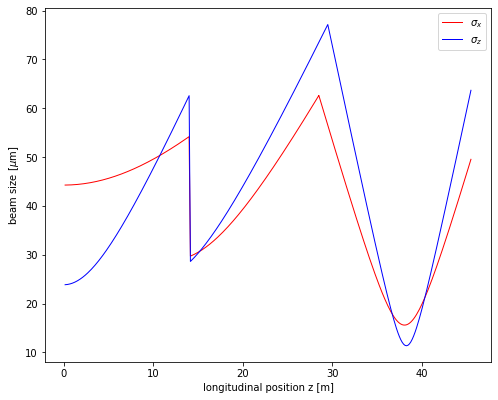

In [13]:
# plot stats.s vs sigmax, sigmaz
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(stats.s, numpy.multiply(stats.sigmax, 1e6),'r-', lw = 1, label = r'$\sigma_x$')
ax.plot(stats.s, numpy.multiply(stats.sigmaz,1e6),'b-', lw = 1, label = r'$\sigma_z$')
ax.set_xlabel(r'longitudinal position z [m]')
ax.set_ylabel(r'beam size [$\mu$m]')
ax.legend()
# plt.xlim(0, 38)
# plt.ylim(0, 0.0012)
fig.show()

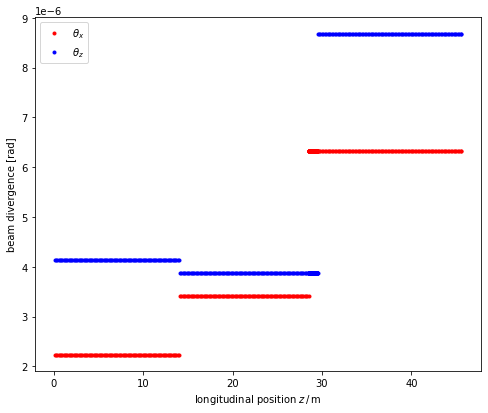

In [15]:
# plot stats.s vs thetax, thetaz
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(stats.s, stats.sigdix,'r.', lw = 1, label = r'$\theta_x$')
ax.plot(stats.s, stats.sigdiz,'b.', lw = 1, label = r'$\theta_z$')
ax.set_xlabel(r'longitudinal position $z\,/\,\mathrm{m}$')
ax.set_ylabel(r'beam divergence [rad]')
ax.legend()
# plt.xlim(0, 38)
# plt.ylim(0, 0.0012)
fig.show()

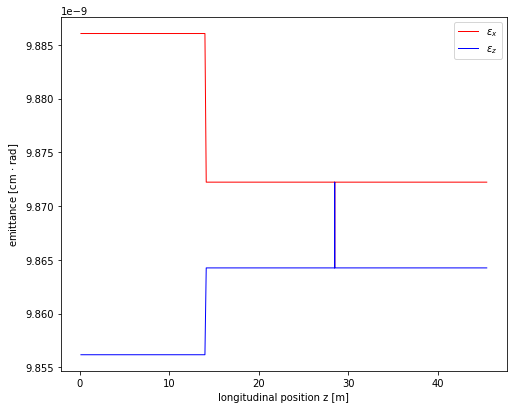

In [16]:
# plot stats.s vs emit_x, emit_z
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(stats.s, numpy.multiply(emit_x_vals, 1),'r-', lw = 1, label = r'$\epsilon_x$')
ax.plot(stats.s, numpy.multiply(emit_z_vals, 1),'b-', lw = 1, label = r'$\epsilon_z$')
ax.set_xlabel(r'longitudinal position z [m]')
ax.set_ylabel(r'emittance [cm $\cdot$ rad]')
ax.legend()
# plt.xlim(0, 38)
# plt.ylim(0, 0.0012)
fig.show()

In [17]:
print('max ps_dens_x_init: %s' %(numpy.max(ps_dens_x_init)))
print('min ps_dens_x_init: %s' %(numpy.min(ps_dens_x_init)))

max ps_dens_x_init: 15968260.630000092
min ps_dens_x_init: 6.776426564734648e-144


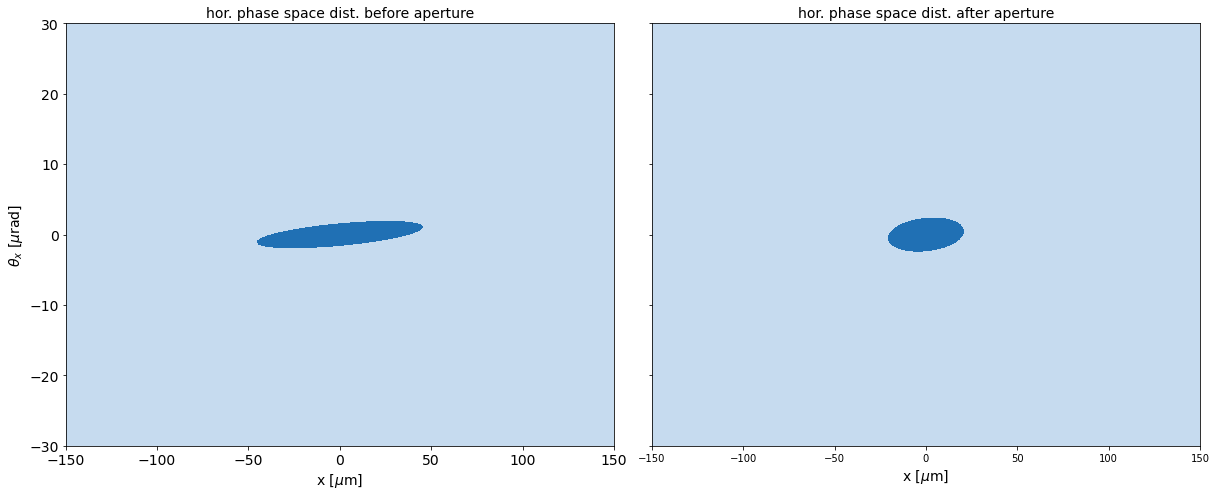

In [39]:
cmap = 'Blues'
levels = 1

fig1, axs = plt.subplots(nrows=1,ncols=2, figsize=(17, 7),sharex='col', sharey='row')
(ax1, ax2) = axs

cs1 = ax1.contourf(numpy.multiply(ps_X, 1e4), numpy.multiply(ps_thetaX, 1e6), ps_dens_x_init, levels=levels, cmap=cmap)
ax1.set_ylabel(r'$\theta_x$ [$\mu$rad]', fontsize=14)
ax1.set_xlabel(r'x [$\mu$m]', fontsize=14)
ax1.tick_params(labelsize=14)
ax1.set_title('hor. phase space dist. before aperture', fontsize=14)
# ax1.set_aspect('equal')

cs2 = ax2.contourf(numpy.multiply(ps_X, 1e4), numpy.multiply(ps_thetaX, 1e6), ps_dens_x_fin, levels=levels, cmap=cmap)
ax2.set_xlabel(r'x [$\mu$m]', fontsize=14)
ax2.set_title('hor. phase space dist. after aperture', fontsize=14)
# ax2.set_aspect('equal')


plt.tight_layout()
plt.show()

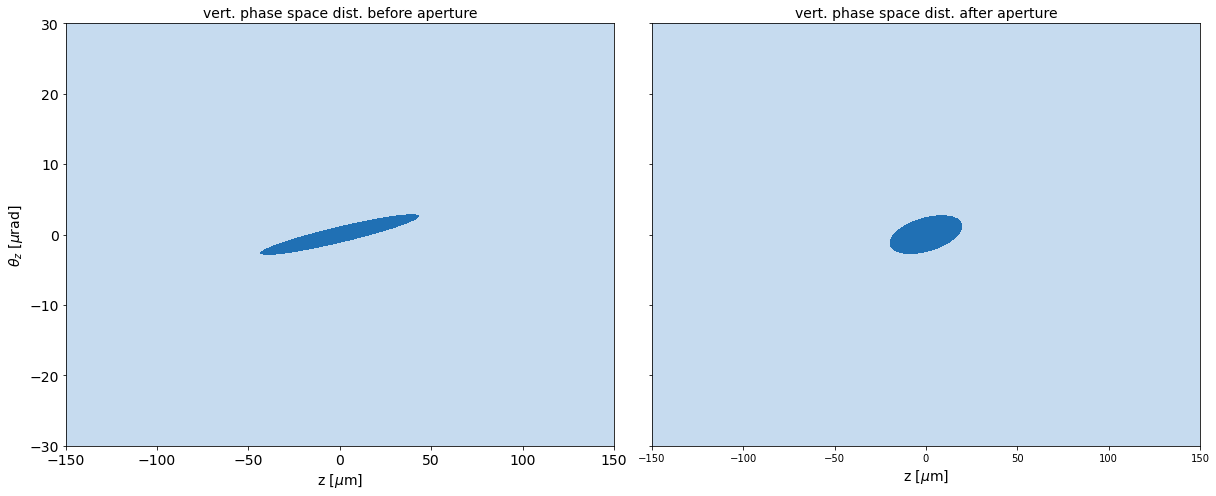

In [40]:

fig1, axs = plt.subplots(nrows=1,ncols=2, figsize=(17, 7), sharex='col', sharey='row')
(ax1, ax2) = axs

cs1 = ax1.contourf(numpy.multiply(ps_Z, 1e4), numpy.multiply(ps_thetaZ, 1e6), ps_dens_z_init, levels=levels, cmap=cmap)
ax1.set_ylabel(r'$\theta_z$ [$\mu$rad]', fontsize=14)
ax1.set_xlabel(r'z [$\mu$m]', fontsize=14)
ax1.tick_params(labelsize=14)
ax1.set_title('vert. phase space dist. before aperture', fontsize=14)
# ax1.set_aspect('equal')

cs2 = ax2.contourf(numpy.multiply(ps_Z, 1e4), numpy.multiply(ps_thetaZ, 1e6), ps_dens_z_fin, levels=levels, cmap=cmap)
ax2.set_xlabel(r'z [$\mu$m]', fontsize=14)
ax2.set_title('vert. phase space dist. after aperture', fontsize=14)
# ax2.set_aspect('equal')


plt.tight_layout()
plt.show()

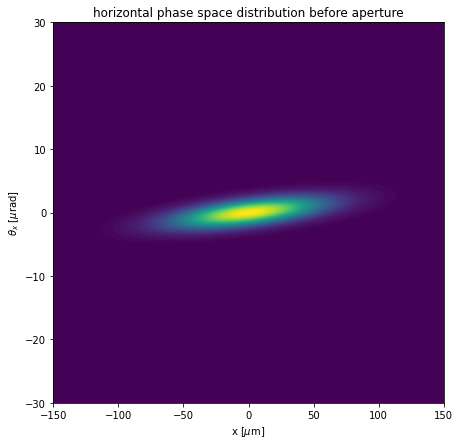

NameError: name 'df1' is not defined

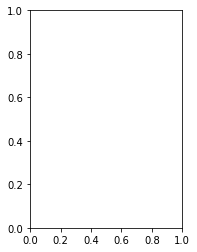

In [19]:
plt.figure(figsize=(7, 7))
ax = fig.gca()
plt.contourf(numpy.multiply(ps_X, 1e4), numpy.multiply(ps_thetaX, 1e6), ps_dens_x_init, 100)
plt.xlabel(r'x [$\mu$m]')
plt.ylabel(r'$\theta_x$ [$\mu$rad]')
plt.title('horizontal phase space distribution before aperture')
plt.show()

fig = plt.figure()

ax1 = fig.add_subplot(121)
df1.plot.bar(stacked=True,ax=ax1)



ax2 = fig.add_subplot(122)
ax2.plot(df2['avg_hour'])

ax3 = ax2.twinx()
ax3.bar(left=range(2009,2016),height=df2['usage'])

plt.show()

In [ ]:
plt.figure(figsize=(7, 7))
ax = fig.gca()
plt.contourf(numpy.multiply(ps_X, 1e4), numpy.multiply(ps_thetaX, 1e6), ps_dens_x_init, 100)
plt.xlabel(r'x [$\mu$m]')
plt.ylabel(r'$\theta_x$ [$\mu$rad]')
plt.title('horizontal phase space distribution before aperture')
plt.show()

In [ ]:
# this shows the beamline 
plt.figure(figsize=(12,3))
plt.plot(stats.s, stats.sigmax, 'b-', label = r'$\sigma_x$')
plt.plot(stats.s, stats.sigmaz, 'r-', label = r'$\sigma_z$')
plt.legend()
plt.show()

In [ ]:
# plot stats.s vs sigmax, sigmaz
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(stats.s, stats.sigmax,'r.', lw = 1, label = r'$\sigma_x$')
ax.plot(stats.s, stats.sigmaz,'b.', lw = 1, label = r'$\sigma_z$')
ax.set_xlabel(r'longitudinal position $z\,/\,\mathrm{m}$')
ax.set_ylabel(r'beam size [m]')
ax.legend()
# plt.xlim(0, 38)
# plt.ylim(0, 0.0012)
fig.show()

In [ ]:
# plot stats.s vs sigmax, sigmaz
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(stats.s, stats.sigmax,'r-.', lw = 1, label = r'$\sigma_x$')
# ax.plot(stats.s, stats.sigmaz,'b.', lw = 1, label = r'$\sigma_z$')
ax.set_xlabel(r'longitudinal position $z\,/\,\mathrm{m}$')
ax.set_ylabel(r'beam size [m]')
ax.legend()
plt.xlim(0, .6)
plt.ylim(0, 0.0003)
fig.show()

In [ ]:
# plot stats.s vs sigmax, sigmaz
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
# ax.plot(stats.s, stats.sigmax,'r.', lw = 1, label = r'$\sigma_x$')
ax.plot(stats.s, stats.sigmaz,'b.', lw = 1, label = r'$\sigma_z$')
ax.set_xlabel(r'longitudinal position $z\,/\,\mathrm{m}$')
ax.set_ylabel(r'beam size [m]')
ax.legend()
# plt.xlim(0, 38)
# plt.ylim(0, 0.0012)
fig.show()